# Selenium 연습문제

## 데이터 수집

In [1]:
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import koreanize_matplotlib

In [2]:
class Gas_Station():
    def __init__(self, driver_path):
        self._oil_dict = {
            '고급휘발유':0,
            '보통휘발유':1,
            '경유':2,
            '실내등유':3
        }
        self.driver = webdriver.Chrome(service=Service(driver_path))
        self._gs_info1 = {}
        self._gs_info2 = {}

    def get_driver(self, url):
        while(1):
            try:    
                self.driver.get(url)
                self.gu_names = self._set_up()
                break
            except:
                continue


    def _select_oil_tab(self, num):
        num_dict = {0:1, 1:0, 2:2, 3:3} 
        tab_window = self.driver.find_element(By.ID, 'templ_list0')
        select_oil = tab_window.find_elements(By.CSS_SELECTOR, 'li')
        select_oil[num].click()
        window = tab_window.find_elements(By.CLASS_NAME, 't_center.overflow_gis.mgb_7')[num_dict[num]]
        # print(name[window.get_attribute('id')])
        return window
    
    def _set_up(self):
        # List Up
        sido = self.driver.find_element(By.ID, 'SIDO_NM0')
        sido_list = sido.find_elements(By.TAG_NAME, 'option')
        sido_names = [sido_name.get_attribute('value') for sido_name in sido_list]
        sido_names.remove('')

        gu = self.driver.find_element(By.ID, 'SIGUNGU_NM0')
        gu_list = gu.find_elements(By.TAG_NAME, 'option')
        gu_names = [gu_name.get_attribute('value') for gu_name in gu_list]
        gu_names.remove('')

        # 부가정보 체크
        add_info_check = self.driver.find_elements(By.CLASS_NAME, 'check_type1_img')[-1]
        for info in add_info_check.find_elements(By.TAG_NAME, 'li'):
            check = info.find_element(By.TAG_NAME, 'input')
            check.click()

        return gu_names
    
    # 주유소 리스트 
    def _get_gas_stations(self, window):
        tbody = window.find_element(By.TAG_NAME, 'tbody')
        gas_stations = tbody.find_elements(By.TAG_NAME, 'tr')
        return gas_stations
    

    # 선택 후 팝업창 띄움
    def _pop_up_station(self, gas_station):
        try:
            gas_station.find_element(By.CLASS_NAME, 'ic.ico_self')
            self_ysc = 'O'
        except:
            self_ysc = 'X'
        self_ys = self_ysc
        station_pop = gas_station.find_element(By.TAG_NAME, 'a')
        station_pop.click()
        soup = BeautifulSoup(self.driver.page_source, 'html.parser')
        pop_up = soup.find('div', 'gis_detail_info_box')
        return pop_up, self_ys
    
    def _make_new_dict(self, pop_up):
        station_info_dict = {
        '전화번호':[],
        '주소':[],
        '상표':[]
        }
        self_ys = {
            '셀프여부':[]
        }

        # 유가 정보
        oil_names = [name.string for name in pop_up.find('tbody').find_all('td', 'nobd_l')]
        oil_dict = dict(zip(oil_names, [[],[],[],[]]))        

        # 부가 정보
        add_info = pop_up.find('div', 'service')
        add_info_list = [name.get_attribute_list('alt')[0] for name in add_info.find_all('img')]
        add_info_dict = dict(zip(add_info_list, [[],[],[],[],[]]))

        return station_info_dict | oil_dict | self_ys | add_info_dict
    
    def _get_info(self, pop_up, selys):

        # 부가 정보
        add_info = pop_up.find('div', 'service')
        station_info = [each.get_text().split(': ')[-1] for i, each in enumerate(pop_up.find_all('li'))]
        oil_price = [name.get_text().strip('원') for name in pop_up.find('tbody').find_all('td') if '원' in name.get_text()][:-1]
        infos = ['O' if 'off' not in yes.get_attribute_list('src')[0] else 'X' for yes in add_info.find_all('img')]
        self_ys = [selys]
        infomation = station_info + oil_price + self_ys + infos

        return infomation

    def _fill_into_dict(self, dictionary, information):
        for i, key in enumerate(dictionary):
            
            dictionary[key].append(information[i])
        return dictionary

    def find(self, location):
        assert location in self.gu_names, f'입력하신 지역({location})은 서울내 존재하지 않습니다. \n서울내 지역을 검색해 주세요.'
        self._gs_info1 = {}
        self._gs_info2 = {}        
        print(f'{location}의 주유소 정보 탐색중...\n')
        gu = self.driver.find_element(By.ID, 'SIGUNGU_NM0')
        gu.send_keys(location)
        for oil, num in self._oil_dict.items():
            window = self._select_oil_tab(num)
            gas_stations = self._get_gas_stations(window)

            pbar = tqdm(gas_stations,
                desc=f'{oil}',
                total=len(gas_stations),
                ncols=80,
                leave=True)
            
            for i, gas_station in enumerate(pbar):
                pop_up, selys = self._pop_up_station(gas_station)
                if i==0:
                    infomation_dict = self._make_new_dict(pop_up)
                # img_link = gas_station.find_element(By.TAG_NAME, 'img').get_attribute('src')
                infomation = self._get_info(pop_up, selys)
                infomation_dict = self._fill_into_dict(infomation_dict, infomation)
            drop_name = self.get_oil_list()
            drop_name.remove(oil)
            self._gs_info1[oil] = pd.DataFrame(infomation_dict).drop(drop_name, axis=1)
            self._gs_info2[oil] = pd.DataFrame(infomation_dict)
            # break
            
        print(f'\nDone!')
                
                
    def get_gu_list(self):
        return self.gu_names
    
    def get_oil_list(self):
        return list(self._oil_dict.keys())
    
    def get_result(self, mode=0): # mode=0 : 개별 정보만 표시, mode=1 : 모든 정보 표시
        assert len(self._gs_info1) != 0, 'find(지역)을 먼저 실행해주세요'
        if mode==1:
            return self._gs_info2
        else:
            return self._gs_info1
        


In [3]:
driver_path = './../driver/chromedriver-linux64/chromedriver'
url = 'https://www.opinet.co.kr/searRgSelect.do#'

gas = Gas_Station(driver_path)
gas.get_driver(url)

In [4]:
print(gas.get_gu_list())
print(gas.get_oil_list())

['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구']
['고급휘발유', '보통휘발유', '경유', '실내등유']


In [5]:
gas.find('강남구')

강남구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 4/4 [00:01<00:00,  3.71it/s]


Done!


In [6]:
# 정보표시 비교 mode=1
# 주유소 모든 기름 가격 정보 표시
result = gas.get_result(mode=1)

In [7]:
result['고급휘발유'].head()

,전화번호,주소,상표,고급휘발유,보통휘발유,경유,실내등유,셀프여부,세차장,충전소,경정비,편의점,24시영업
0,02-445-6870,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,839","1,668","1,529",,O,O,X,X,X,X
1,02-529-5101,서울 강남구 남부순환로 2718,HD현대오일뱅크,"1,879","1,699","1,579",,O,O,X,O,X,X
2,02-3462-5215,서울 강남구 논현로 152 (도곡동),HD현대오일뱅크,"1,894","1,709","1,594","1,570",X,O,X,O,X,X
3,02-3462-5100,서울 강남구 남부순환로 2651 (도곡동),SK에너지,"1,910","1,705","1,594",,O,O,X,O,X,O
4,070-8707-4582,서울 강남구 광평로 202 (수서동),SK에너지,"1,917","1,727","1,597",,O,O,X,X,X,X


In [8]:
# 정보표시 비교 mode=0
# 주유소 선택한 기름 가격만 표시
result = gas.get_result(mode=0)

In [9]:
result['고급휘발유'].head()

,전화번호,주소,상표,고급휘발유,셀프여부,세차장,충전소,경정비,편의점,24시영업
0,02-445-6870,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,839",O,O,X,X,X,X
1,02-529-5101,서울 강남구 남부순환로 2718,HD현대오일뱅크,"1,879",O,O,X,O,X,X
2,02-3462-5215,서울 강남구 논현로 152 (도곡동),HD현대오일뱅크,"1,894",X,O,X,O,X,X
3,02-3462-5100,서울 강남구 남부순환로 2651 (도곡동),SK에너지,"1,910",O,O,X,O,X,O
4,070-8707-4582,서울 강남구 광평로 202 (수서동),SK에너지,"1,917",O,O,X,X,X,X


In [10]:
result['보통휘발유'].head()

,전화번호,주소,상표,보통휘발유,셀프여부,세차장,충전소,경정비,편의점,24시영업
0,02-445-6870,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,668",O,O,X,X,X,X
1,02-2226-4963,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,675",O,O,X,X,X,X
2,02-459-3434,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,677",O,O,X,X,X,X
3,02-3462-0018,서울 강남구 도곡로 208,HD현대오일뱅크,"1,679",O,O,X,X,X,X
4,02-445-5841,서울 강남구 밤고개로 120 (자곡동),SK에너지,"1,698",O,O,X,X,X,X


In [11]:
result['경유'].head()

,전화번호,주소,상표,경유,셀프여부,세차장,충전소,경정비,편의점,24시영업
0,02-445-6870,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,529",O,O,X,X,X,X
1,02-2226-4963,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,529",O,O,X,X,X,X
2,02-459-3434,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,559",O,O,X,X,X,X
3,02-445-5841,서울 강남구 밤고개로 120 (자곡동),SK에너지,"1,569",O,O,X,X,X,X
4,02-3462-0018,서울 강남구 도곡로 208,HD현대오일뱅크,"1,579",O,O,X,X,X,X


In [12]:
result['실내등유']

,전화번호,주소,상표,실내등유,셀프여부,세차장,충전소,경정비,편의점,24시영업
0,02-3462-5215,서울 강남구 논현로 152 (도곡동),HD현대오일뱅크,"1,570",X,O,X,O,X,X
1,02-573-9031,서울 강남구 양재대로 339,GS칼텍스,"1,600",O,O,X,X,X,X
2,02-565-0267,서울 강남구 삼성로 335,GS칼텍스,"1,650",X,O,X,X,X,X
3,02-511-0955,서울 강남구 논현로 747 (논현동),SK에너지,"1,750",X,O,X,O,X,O


## 데이터 분석

- 위치에 따른 가격 분석

In [13]:
import googlemaps
import copy
gmaps_key = ''
gmaps = googlemaps.Client(key=gmaps_key)

gu = {}
for gu_name in gas.get_gu_list():
    gas.find(gu_name)
    gu[gu_name] = copy.deepcopy(gas.get_result())
    print()

강남구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 4/4 [00:01<00:00,  3.44it/s]



Done!

강동구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 5/5 [00:00<00:00,  5.13it/s]



Done!

강북구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]



Done!

강서구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]



Done!

관악구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 4/4 [00:00<00:00,  4.58it/s]



Done!

광진구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]



Done!

구로구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]



Done!

금천구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 3/3 [00:00<00:00,  3.29it/s]



Done!

노원구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 4/4 [00:01<00:00,  3.92it/s]



Done!

도봉구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]



Done!

동대문구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 3/3 [00:00<00:00,  4.48it/s]



Done!

동작구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]



Done!

마포구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]



Done!

서대문구의 주유소 정보 탐색중...



경유: 100%|█████████████████████████████████████| 12/12 [00:04<00:00,  2.93it/s]
실내등유: 0it [00:00, ?it/s]



Done!

서초구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]



Done!

성동구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.18it/s]



Done!

성북구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 3/3 [00:01<00:00,  1.60it/s]



Done!

송파구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 4/4 [00:02<00:00,  1.91it/s]



Done!

양천구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]



Done!

영등포구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 3/3 [00:00<00:00,  4.46it/s]



Done!

용산구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 4/4 [00:00<00:00,  4.83it/s]



Done!

은평구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 5/5 [00:00<00:00,  5.15it/s]



Done!

종로구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]



Done!

중구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 3/3 [00:01<00:00,  1.64it/s]



Done!

중랑구의 주유소 정보 탐색중...



실내등유: 100%|███████████████████████████████████| 5/5 [00:00<00:00,  5.12it/s]


Done!



In [14]:
gu['강남구']['보통휘발유'].head()

,전화번호,주소,상표,보통휘발유,셀프여부,세차장,충전소,경정비,편의점,24시영업
0,02-445-6870,서울 강남구 헌릉로 731 (세곡동),SK에너지,"1,668",O,O,X,X,X,X
1,02-2226-4963,서울 강남구 헌릉로 730,HD현대오일뱅크,"1,675",O,O,X,X,X,X
2,02-459-3434,서울 강남구 밤고개로 215 (율현동),GS칼텍스,"1,677",O,O,X,X,X,X
3,02-3462-0018,서울 강남구 도곡로 208,HD현대오일뱅크,"1,679",O,O,X,X,X,X
4,02-445-5841,서울 강남구 밤고개로 120 (자곡동),SK에너지,"1,698",O,O,X,X,X,X


In [15]:
gu_loc = {}

for gu_name in gu:
    gu_loc[gu_name] = {}
    for gas_name in gu[gu_name]:
        # print()
        # print(gas_name)
        gu_loc[gu_name][gas_name] = {'Lat':[], 'Lng':[]}

        for add in gu[gu_name][gas_name]['주소']:
            # print(add)
            geocode = gmaps.geocode(address=add)
            lat, lng = geocode[0].get('geometry')['location'].values()
            gu_loc[gu_name][gas_name]['Lat'].append(str(lat))
            gu_loc[gu_name][gas_name]['Lng'].append(str(lng))
        gu_loc[gu_name][gas_name] = pd.DataFrame(gu_loc[gu_name][gas_name])
        # break

In [62]:
import folium

colors = [ 'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
     'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 
     'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray',
     'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred']

geocode = gmaps.geocode(address='서울 특별시')
LAT, LNG = geocode[0].get('geometry')['location'].values()
mapping = folium.Map(location=[str(LAT), 
                               str(LNG)], 
                               zoom_start=11)
i = 0 
for gu_name in gas.get_gu_list():
    for col, row in gu_loc[gu_name]['보통휘발유'].iterrows():
        folium.Marker([row['Lat'], row['Lng']], 
                      icon=folium.Icon(color=colors[i], icon='glyphicon-tint')).add_to(mapping)  
    i+=1      

mapping

## 구별 가격 비교

In [17]:
oils = ['고급휘발유', '보통휘발유', '경유', '실내등유']
compare_table_gu = {
    '구':[],
    '평균가격':[],
    '셀프여부':[],
    '세차장':[],
    '충전소':[],
    '경정비':[],
    '편의점':[],
    '24시영업':[]
}
compare_table = dict(zip(oils, [copy.deepcopy(compare_table_gu) for i in range(4)]))

for gu_name in gu:
    price = {}
    add = {}
    for oil in gu[gu_name]:     
        compare_table[oil]['구'].append(gu_name)
        price[oil] = 0
        add[oil] = [0, 0, 0, 0, 0, 0]
        for r, c in gu[gu_name][oil].iterrows():
            p_prcie = float(c[3].replace(',','')) if c[3] != '' else 0
            price[oil] += p_prcie
            for idx, i in enumerate(c[4:]):
                if i == 'O':
                    add[oil][idx] += 1

        compare_table[oil]['평균가격'].append(price[oil]/len(gu[gu_name][oil]))
        keys = list(compare_table_gu.keys())
        for idx, value in enumerate(add[oil]):
            compare_table[oil][keys[idx+2]].append(value)
        # compare_table[oil] = compare_table_gu


/tmp/ipykernel_531363/3148082106.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_prcie = float(c[3].replace(',','')) if c[3] != '' else 0


In [18]:
for key in compare_table:
    compare_table[key] = pd.DataFrame(compare_table[key]).set_index('구')

compare_table['보통휘발유'].head()

,평균가격,셀프여부,세차장,충전소,경정비,편의점,24시영업
구,,,,,,,
강남구,1920.862069,18,27,0,9,0,12
강동구,1778.916667,8,12,0,5,1,1
강북구,1611.000000,8,7,0,2,1,2
강서구,1685.148148,17,25,2,9,8,8
관악구,1706.200000,4,10,0,3,2,2


- 시각화

In [19]:
import json 

geo_path = '../data/skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles='OpenStreetMap')
setting = folium.Choropleth(
    geo_data=geo_str,
    data=compare_table['보통휘발유'],
    columns=[compare_table['보통휘발유'].index, '평균가격'],
    key_on='properties.name',
    fill_color='PuRd')
setting.add_to(map)
map

- 구별 가격 비교 시각화 및 정렬

<Axes: title={'center': '휘발유 가격 순위'}, ylabel='구'>

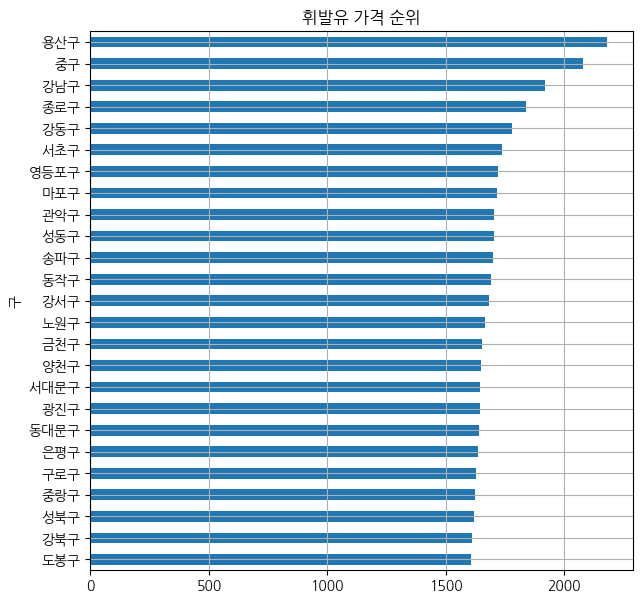

In [20]:
compare_table['보통휘발유']['평균가격'].sort_values().plot(
    kind='barh', grid=True, 
    title='휘발유 가격 순위', 
    figsize=(7, 7))

- 지역별 가격 변화는 확실함

## 부가 여부에 따른 가격 분석

- 데이터 상관계수 확인
  - heatmap 사용

셀프여부    -0.187976
세차장      0.191725
충전소     -0.114273
경정비      0.160242
편의점     -0.099783
24시영업    0.193173
Name: 평균가격, dtype: float64


<Axes: >

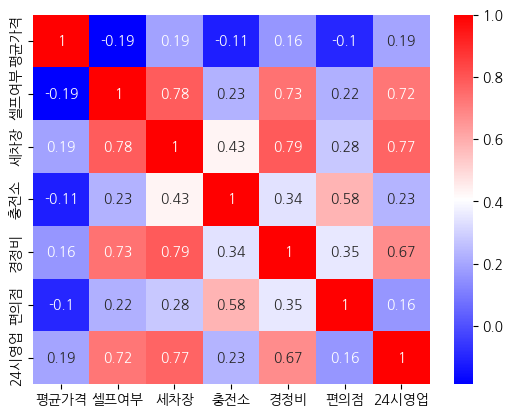

In [21]:
import seaborn as sns
print(compare_table['고급휘발유'].corr().iloc[0][1:])
sns.heatmap(compare_table['고급휘발유'].corr(), annot=True, cmap='bwr')

셀프여부    -0.392584
세차장     -0.035279
충전소     -0.064708
경정비      0.033918
편의점     -0.107701
24시영업    0.113147
Name: 평균가격, dtype: float64


<Axes: >

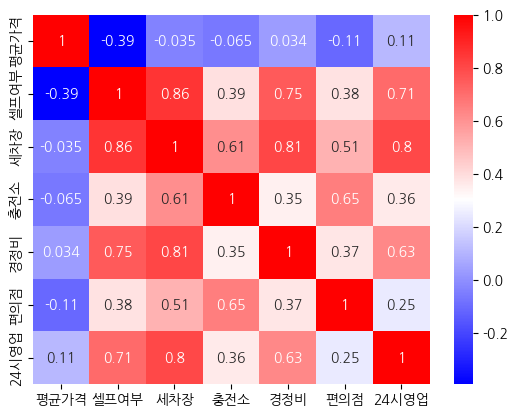

In [22]:
print(compare_table['보통휘발유'].corr().iloc[0][1:])
sns.heatmap(compare_table['보통휘발유'].corr(), annot=True, cmap='bwr')

셀프여부    -0.393412
세차장     -0.043969
충전소     -0.049262
경정비      0.010161
편의점     -0.089871
24시영업    0.116834
Name: 평균가격, dtype: float64


<Axes: >

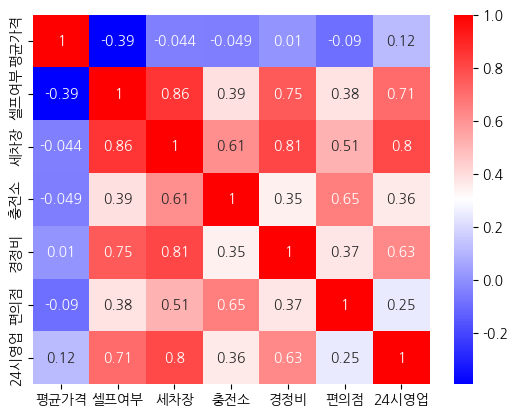

In [23]:
print(compare_table['경유'].corr().iloc[0][1:])
sns.heatmap(compare_table['경유'].corr(), annot=True, cmap='bwr')

셀프여부    -0.818890
세차장     -0.700826
충전소      0.016104
경정비     -0.559955
편의점     -0.852467
24시영업   -0.023600
Name: 평균가격, dtype: float64


<Axes: >

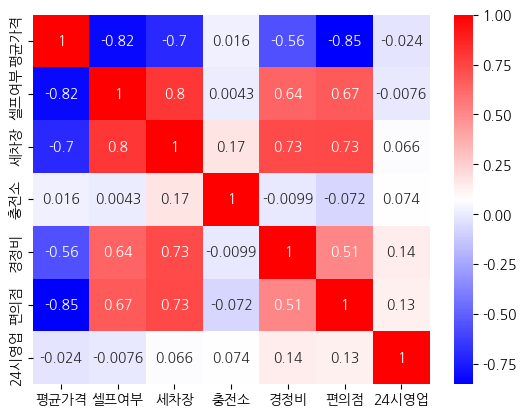

In [24]:
print(compare_table['실내등유'].corr().iloc[0][1:])
sns.heatmap(compare_table['실내등유'].corr(), annot=True, cmap='bwr')

- 부가 여부는 가격 상승에 영향을 미치지 않는 걸로 보인다.
  - 오히려 가격이 저렴해짐

## 상표에 따른 가격 분석

In [25]:
oils = ['고급휘발유', '보통휘발유', '경유', '실내등유']
compare_table_gu = {
    '구':[],
    '상표':[],
    '가격':[],
    '셀프여부':[],
    '세차장':[],
    '충전소':[],
    '경정비':[],
    '편의점':[],
    '24시영업':[]
}
compare_table2 = dict(zip(oils, [copy.deepcopy(compare_table_gu) for i in range(4)]))

for gu_name in gu:
    for oil in gu[gu_name]:
        # print(gu[gu_name][oil])
        for r, c in gu[gu_name][oil].iterrows():
            compare_table2[oil]['구'].append(gu_name)
            keys = list(compare_table_gu.keys())[1:]
            for idx, key in enumerate(keys):
                try:
                    val = c[2:][idx] if idx != 1 else float(c[2:][idx].replace(',',''))
                except:
                    val = 0
                compare_table2[oil][key].append(val)

for oil in compare_table2:
    compare_table2[oil] = pd.DataFrame(compare_table2[oil])

/tmp/ipykernel_531363/1620875002.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = c[2:][idx] if idx != 1 else float(c[2:][idx].replace(',',''))


In [26]:
compare_table2['보통휘발유'].head()

,구,상표,가격,셀프여부,세차장,충전소,경정비,편의점,24시영업
0,강남구,SK에너지,1668.0,O,O,X,X,X,X
1,강남구,HD현대오일뱅크,1675.0,O,O,X,X,X,X
2,강남구,GS칼텍스,1677.0,O,O,X,X,X,X
3,강남구,HD현대오일뱅크,1679.0,O,O,X,X,X,X
4,강남구,SK에너지,1698.0,O,O,X,X,X,X


- 상표에 따른 가격 비교 시각화

In [27]:
import matplotlib.pyplot as plt

# 자주 쓰이니 함수화
def show_box_plot(x, data, hue):
    plt.figure(figsize=(8,6))
    sns.boxplot(x=x, y='가격', data=data, hue=hue, palette='Set3')
    plt.grid(True)
    plt.show()

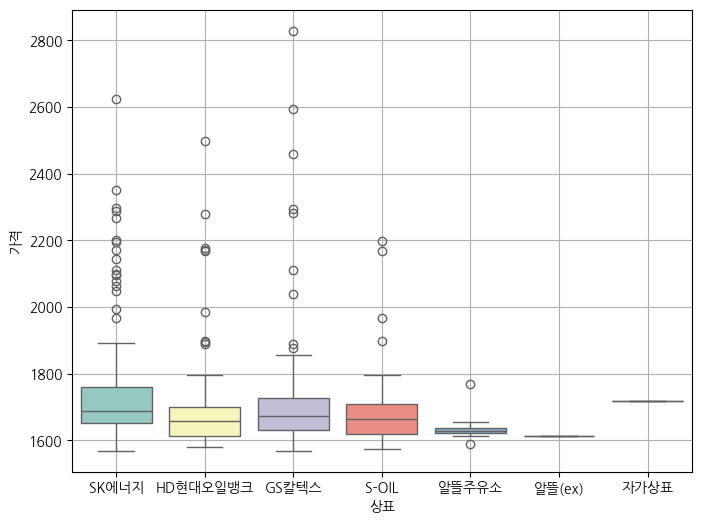

In [28]:
show_box_plot('상표', compare_table2['보통휘발유'], '상표')

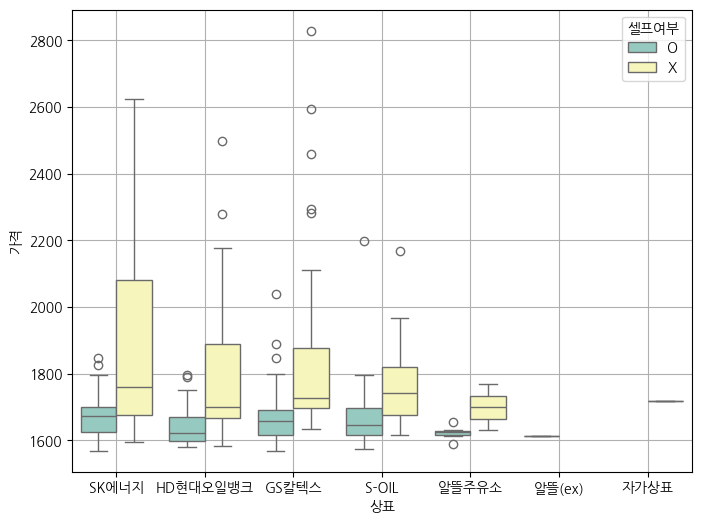

In [29]:
show_box_plot('상표', compare_table2['보통휘발유'], '셀프여부')

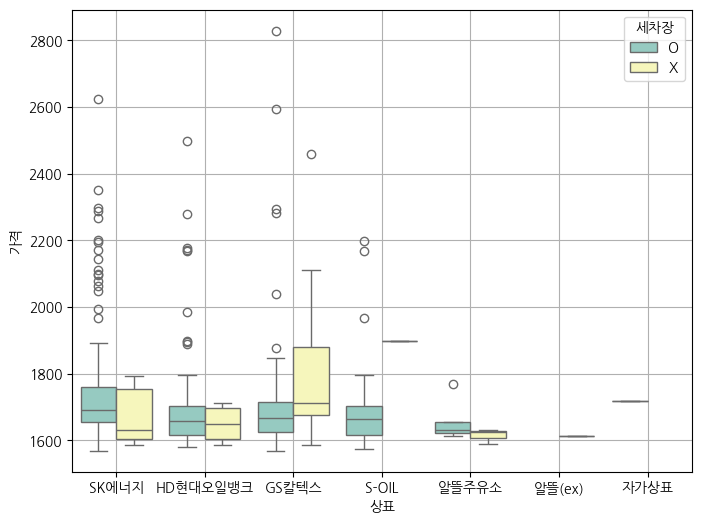

In [30]:
show_box_plot('상표', compare_table2['보통휘발유'], '세차장')

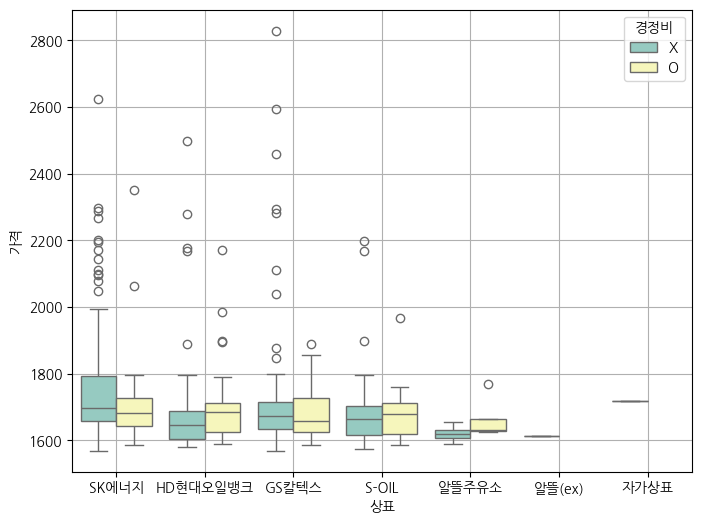

In [31]:
show_box_plot('상표', compare_table2['보통휘발유'], '경정비')

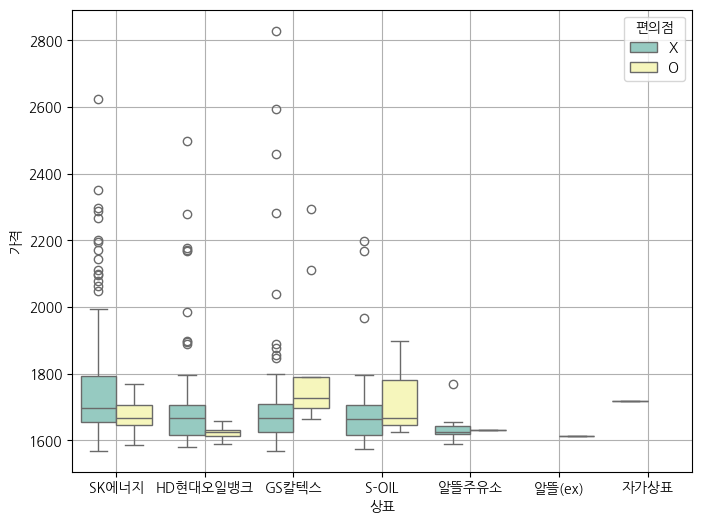

In [32]:
show_box_plot('상표', compare_table2['보통휘발유'], '편의점')

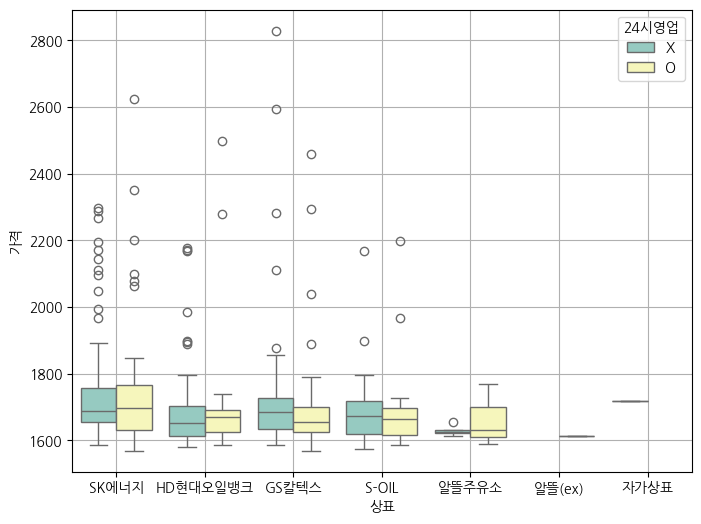

In [33]:
show_box_plot('상표', compare_table2['보통휘발유'], '24시영업')

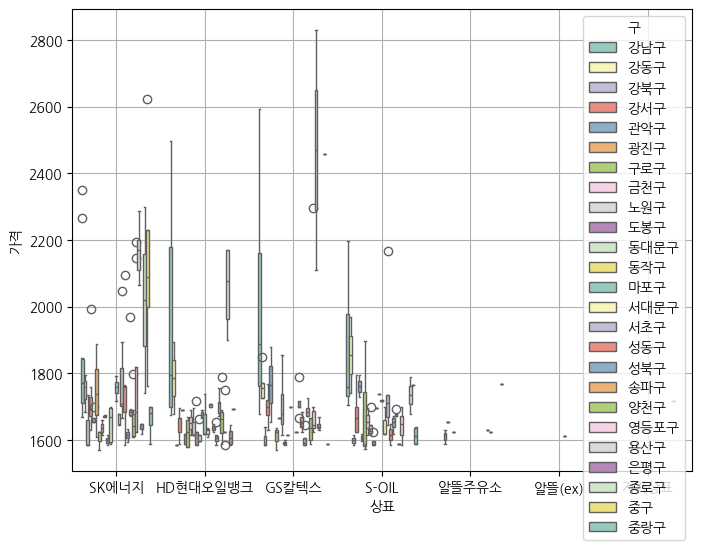

In [34]:
show_box_plot('상표', compare_table2['보통휘발유'], '구')

- 위치와 셀프 여부에 따른 가격 변화와 가장 커 보임

- 상표에 따라 가격을 분류해 봤을 때, SK에너지가 가장 높게 나왔으며 대부분 부가시스템이 없을 때 더 높게 가격이 측정됨. 
  - 그나마, 세차 서비스가 있는 경우에, 대체로 가격이 높게 측정됨
- 가격이 높아지는 원인 분석에는 추가적인 데이터가 필요해 보임 (인구 유동 등)

# 가격상승 원인을 좀 더 분석해보자

- 휘발유 유무에 따른 분석

In [35]:
oils = ['고급휘발유', '보통휘발유', '경유', '실내등유']
compare_table_gu = {
    '구':[],
    '주소':[],
    '상표':[],
    '가격':[],
    '셀프여부':[],
    '세차장':[],
    '충전소':[],
    '경정비':[],
    '편의점':[],
    '24시영업':[]
}
compare_table3 = dict(zip(oils, [copy.deepcopy(compare_table_gu) for i in range(4)]))

for gu_name in gu:
    for oil in gu[gu_name]:
        # print(gu[gu_name][oil])
        for r, c in gu[gu_name][oil].iterrows():
            compare_table3[oil]['구'].append(gu_name)
            keys = list(compare_table_gu.keys())[1:]
            for idx, key in enumerate(keys):
                try:
                    val = c[1:][idx] if idx != 2 else float(c[1:][idx].replace(',',''))
                except:
                    val = 0
                compare_table3[oil][key].append(val)

for oil in compare_table3:
    compare_table3[oil] = pd.DataFrame(compare_table3[oil])


/tmp/ipykernel_531363/3027855523.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = c[1:][idx] if idx != 2 else float(c[1:][idx].replace(',',''))


In [36]:
normal_add = compare_table3['보통휘발유'].set_index('주소')
luxary_price = pd.DataFrame({'고급휘발유':compare_table3['고급휘발유'].set_index('주소')['가격']})
diesel_price = pd.DataFrame({'경유':compare_table3['경유'].set_index('주소')['가격']})
deung_price = pd.DataFrame({'실내등유':compare_table3['실내등유'].set_index('주소')['가격']})

names = '구 상표 가격 셀프여부 세차장 충전소 경정비 편의점 24시영업 고급휘발유'.split(' ')
data_concat = pd.merge(normal_add, luxary_price, how='left', on='주소')
data_concat = pd.merge(data_concat,diesel_price, how='left', on='주소')
data_concat = pd.merge(data_concat, deung_price, how='left', on='주소')
new_data2 = data_concat.fillna(0)

In [63]:
for oil in ['고급휘발유', '경유', '실내등유']:
    new_data2.loc[new_data2[oil] != 0, oil] = 'O'
    new_data2.loc[new_data2[oil] == 0, oil] = 'X'
new_data2.head()

,구,상표,가격,셀프여부,세차장,충전소,경정비,편의점,24시영업,고급휘발유,경유,실내등유
주소,,,,,,,,,,,,
서울 강남구 헌릉로 731 (세곡동),강남구,SK에너지,1668.0,O,O,X,X,X,X,O,O,O
서울 강남구 헌릉로 730,강남구,HD현대오일뱅크,1675.0,O,O,X,X,X,X,O,O,O
서울 강남구 밤고개로 215 (율현동),강남구,GS칼텍스,1677.0,O,O,X,X,X,X,O,O,O
서울 강남구 도곡로 208,강남구,HD현대오일뱅크,1679.0,O,O,X,X,X,X,O,O,O
서울 강남구 밤고개로 120 (자곡동),강남구,SK에너지,1698.0,O,O,X,X,X,X,O,O,O


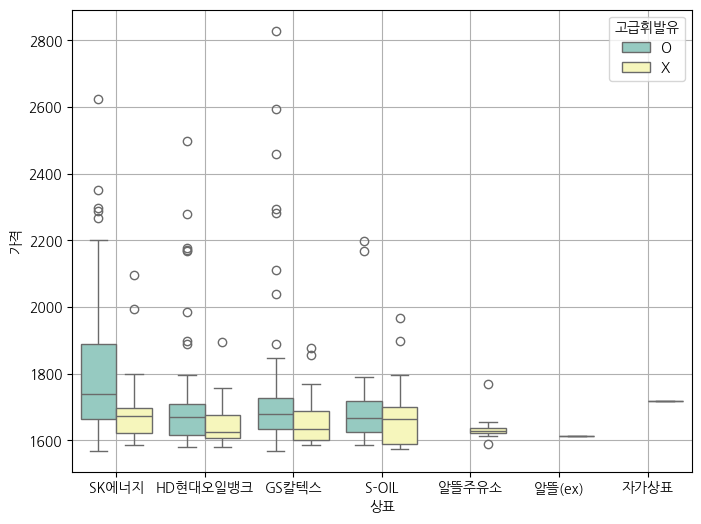

In [38]:
show_box_plot('상표', new_data2, '고급휘발유')

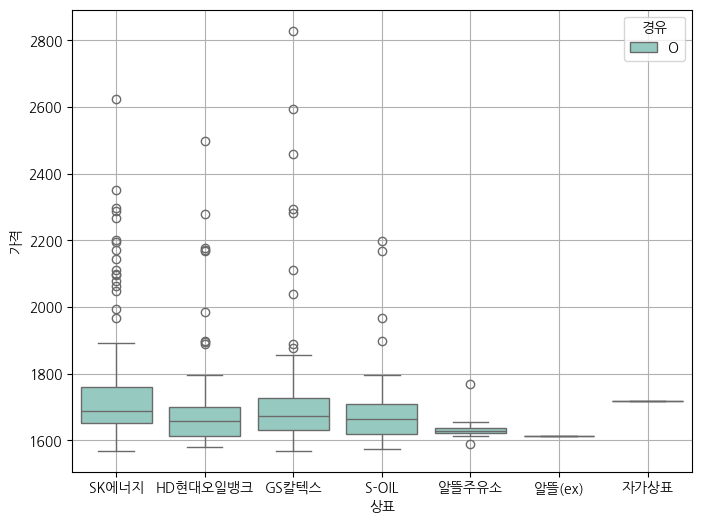

In [39]:
show_box_plot('상표', new_data2, '경유')

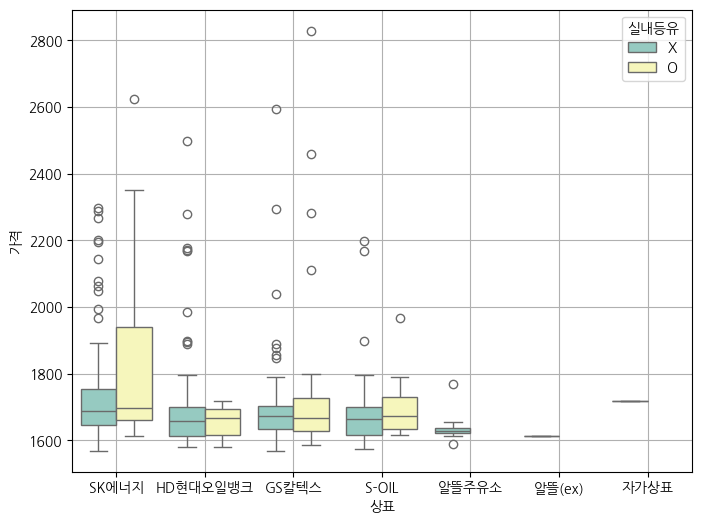

In [40]:
show_box_plot('상표', new_data2, '실내등유')

- 레이블링 작업을 통해 confusion maxtrix 분석

In [41]:
c = new_data2.columns
new_data3 = new_data2[c[2:]]
new_data3
for key in c[3:]:
    new_data3.loc[new_data3[key]=='O', key] = 1
    new_data3.loc[new_data3[key]=='X', key] = 0
new_data3.head()

,가격,셀프여부,세차장,충전소,경정비,편의점,24시영업,고급휘발유,경유,실내등유
주소,,,,,,,,,,
서울 강남구 헌릉로 731 (세곡동),1668.0,1,1,0,0,0,0,1,1,0
서울 강남구 헌릉로 730,1675.0,1,1,0,0,0,0,1,1,0
서울 강남구 밤고개로 215 (율현동),1677.0,1,1,0,0,0,0,0,1,0
서울 강남구 도곡로 208,1679.0,1,1,0,0,0,0,1,1,0
서울 강남구 밤고개로 120 (자곡동),1698.0,1,1,0,0,0,0,0,1,0


셀프여부    -0.477712
세차장      0.008369
충전소      0.011192
경정비     -0.065810
편의점     -0.026021
24시영업    0.040009
고급휘발유    0.239528
경유            NaN
실내등유     0.099189
Name: 가격, dtype: float64


<Axes: >

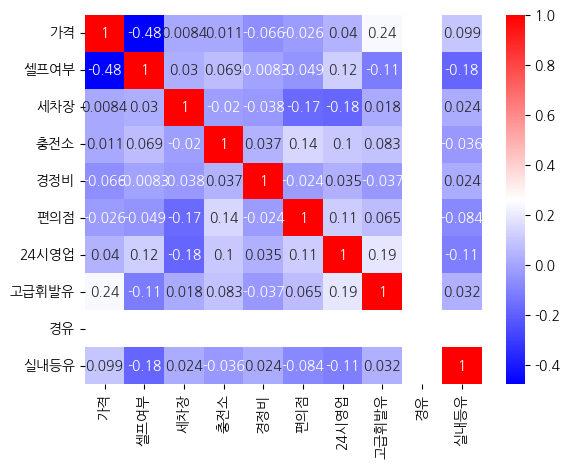

In [42]:
print(new_data3.corr().iloc[0][1:])
sns.heatmap(new_data3.corr(), annot=True, cmap='bwr')

- 고급 휘발유의 유무가 가장 영향력 있어 보임

## 주유소 가격 예측 알고리즘

- 데이터 타입 확인

In [43]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355 entries, 서울 강남구  헌릉로 731 (세곡동) to 서울 중랑구 상봉로 58 (망우동)
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   구       355 non-null    object 
 1   상표      355 non-null    object 
 2   가격      355 non-null    float64
 3   셀프여부    355 non-null    object 
 4   세차장     355 non-null    object 
 5   충전소     355 non-null    object 
 6   경정비     355 non-null    object 
 7   편의점     355 non-null    object 
 8   24시영업   355 non-null    object 
 9   고급휘발유   355 non-null    object 
 10  경유      355 non-null    object 
 11  실내등유    355 non-null    object 
dtypes: float64(1), object(11)
memory usage: 44.2+ KB


- 영향력이 적은 요소 제거
  - 가격 대비 corr값 0.2 이상 추출

In [44]:
c = new_data2.columns
x_key = list(c[5:9]) + list(c[10:])
new_data4 = new_data2.drop(x_key, axis=1).reset_index().drop('주소', axis=1)
new_data4.head()

,구,상표,가격,셀프여부,세차장,고급휘발유
0,강남구,SK에너지,1668.0,O,O,O
1,강남구,HD현대오일뱅크,1675.0,O,O,O
2,강남구,GS칼텍스,1677.0,O,O,X
3,강남구,HD현대오일뱅크,1679.0,O,O,O
4,강남구,SK에너지,1698.0,O,O,X


- 데이터 생성

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

input_data = pd.DataFrame()
c = new_data4.columns
x_key = list(c[:2]) + list(c[3:])
y_key = '가격'
labeling = [copy.deepcopy(LabelEncoder()) for i in x_key]
    
for i, key in enumerate(x_key):
    labeling[i].fit(new_data4[key])
    input_data[key] = labeling[i].transform(new_data4[key])

input_data[y_key] = new_data4[y_key]

x_data = input_data[x_key]
y_data = input_data[y_key]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=13)

x_train.head()

,구,상표,셀프여부,세차장,고급휘발유
35,1,3,0,0,0
90,5,2,0,0,0
155,10,2,0,0,1
269,18,0,0,0,1
34,1,0,0,0,0


- 임의의 주유소 데이터 가격 예측
  - 수치를 예측해야 하므로 Regression Model 사용
  - 평가지표는 RMSL error 사용

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_log_error

dt = DecisionTreeRegressor(max_depth=10, random_state=6)
dt.fit(x_train, y_train)

pred = dt.predict(x_test)
print(f'Error Rate : {root_mean_squared_log_error(y_test, pred)}')

Error Rate : 0.09237972257711333


---

- 변화 비교 1 : 셀프 여부

In [47]:
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['강남구', 'SK에너지', 'O',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1761.50원


In [48]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['강남구', 'SK에너지', 'X',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 2308.00원


---

- 변화 비교 2 : 세차장

In [49]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['강남구', 'SK에너지', 'O',   'X',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1750.00원


In [50]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['강남구', 'SK에너지', 'O',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1761.50원


---

- 변화 비교 3 : 고급휘발유

In [51]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['강남구', 'SK에너지', 'O',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1761.50원


In [52]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['강남구', 'SK에너지', 'O',   'O',    'X']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1698.00원


---

- 변화 비교 4 : 구

In [53]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['강남구', 'SK에너지', 'O',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1761.50원


In [54]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['금천구', 'SK에너지', 'O',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1620.00원


---

- 변화 비교 5 : 상표

In [55]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['금천구', 'SK에너지', 'O',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1620.00원


In [56]:
            # 구,     상표,   셀프여부, 세차장, 고급휘발유
gasinfo = ['금천구', 'HD현대오일뱅크', 'O',   'O',    'O']
new_gas_satation = np.array([[labeling[i].transform([data])[0] for i, data in enumerate(gasinfo)]])
print(f'예상 주유소 가격 : {dt.predict(new_gas_satation)[0]:.2f}원')

예상 주유소 가격 : 1614.00원


---

- 드라이버 꼭 닫아주기

In [57]:
gas.driver.close()